In [1]:
import numpy as np 
import pandas as pd 
#import pydicom
import matplotlib.pyplot as plt 

import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

from PIL import Image
from skimage.transform import resize
from sklearn.metrics import confusion_matrix, roc_curve, auc

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.model_selection import StratifiedKFold

import xgboost as xgb
from efficientnet_pytorch import EfficientNet

from tqdm import tqdm

In [2]:
# Device configuration (GPU can be enabled in settings)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'
print(device)

cuda:0


In [3]:
train_df = pd.read_csv("ENET_train_df.csv")
val_df = pd.read_csv("ENET_val_df.csv")
path = "../../data-512/512x512-dataset-melanoma/512x512-dataset-melanoma/"

print("Training on {} images, validating on {} images.".format(train_df.shape[0], val_df.shape[0]))

Training on 13609 images, validating on 1513 images.


Add training data on top of data that enet trained on: 

In [4]:
train_df_allsamples = pd.read_csv("../TrainTestDataFrames/marking.csv") 

all_samples = train_df_allsamples['image_id'].values
rm_samples = np.array(list(train_df['image_id'].values) + list(val_df['image_id'].values))

inds = np.in1d(all_samples, rm_samples, invert=True)

more_train = train_df_allsamples.iloc[inds, :].sample(n=2*train_df.shape[0])
train_df = pd.concat((more_train, train_df)).sample(frac=1)
print("Training on {} images, validating on {} images.".format(train_df.shape[0], val_df.shape[0]))

Training on 40827 images, validating on 1513 images.


In [6]:
# First, load the EfficientNet with pre-trained parameters 
ENet = EfficientNet.from_pretrained('efficientnet-b0').to(device)

# Convolutional neural network
class MyENet(nn.Module):
    def __init__(self, ENet):
        super(MyENet, self).__init__()
        # modify output layer of the pre-trained ENet 
        self.ENet = ENet
        num_ftrs = self.ENet._fc.in_features
        self.ENet._fc = nn.Linear(in_features=num_ftrs, out_features=512)
        # map Enet output to melanoma decision 
        self.output = nn.Sequential(nn.BatchNorm1d(512),
                                    nn.LeakyReLU(),
                                    nn.Dropout(p=0.2),
                                    nn.Linear(512, 1), 
                                    nn.Sigmoid())
        
    def embedding(self, x):
        out = self.ENet(x)
        return out 
        
    def forward(self, x):
        out = self.ENet(x)
        out = self.output(out)
        return out

model = MyENet(ENet).to(device)
# Load best model 
model.load_state_dict(torch.load('../Models/ENETmodel.ckpt'))

Loaded pretrained weights for efficientnet-b0


<All keys matched successfully>

In [10]:
meta_features = ['sex', 'age_approx', 'anatom_site_general_challenge'] 

encoder = {}
for feature in meta_features: 
    # determine unique features  
    categories = np.unique(np.array(train_df[feature].values, str))
    for i, category in enumerate(categories): 
        if category != 'nan':
            encoder[category] = np.float(i)
encoder['nan'] = np.nan

# basic transform 
transform_1 = transforms.Compose([
    transforms.RandomRotation(degrees=5),
    transforms.ColorJitter(brightness=32. / 255.,saturation=0.5),
    transforms.RandomResizedCrop(size=256, scale=(0.5, 1.0), ratio=(0.8, 1.2)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])

# no flip or rotation for test/validation data 
transform_valid = transforms.Compose([
    transforms.RandomResizedCrop(size=256, scale=(1.0, 1.0), ratio=(1.0, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
]) 

class TrainDataset(torch.utils.data.Dataset):
    def __init__(self, df, path_to_files):
        # 1. Initialize file paths or a list of file names.
        self.path = path_to_files
        self.df = df

    def __getitem__(self, index):
        # 1. Read one data from file (e.g. using numpy.fromfile, PIL.Image.open).
        
        # load X 
        img_name = self.df['image_id'].values[index]
        img_path = self.path + img_name + ".jpg"
        img = plt.imread(img_path)
        
        # determine meta data 
        meta = self.df[meta_features].values[index]
        meta_data = np.array([encoder[str(m)] for m in meta])
        
        # load y 
        label = self.df["target"].values[index]
        label_encode = np.zeros(2)
        label_encode[label] = 1
        target = torch.tensor(label, dtype=torch.float32)
        
        # 2. Preprocess the data (e.g. torchvision.Transform).
        img = Image.fromarray(img)
        img_processed = transform_1(img)
        
        # 3. get meta data 
        meta = self.df[meta_features].values[index]
        meta_data = np.array([encoder[str(m)] for m in meta])
        
        return img_processed, meta_data, target
        
    def __len__(self):
        # total size of your dataset.
        return self.df.shape[0]

class ValidDataset(torch.utils.data.Dataset):
    def __init__(self, df, path_to_files):
        # 1. Initialize file paths or a list of file names.
        self.path = path_to_files
        self.df = df

    def __getitem__(self, index):
        # 1. Read one data from file (e.g. using numpy.fromfile, PIL.Image.open).
        
        # load X 
        img_name = self.df['image_id'].values[index]
        img_path = self.path + img_name + ".jpg"
        img = plt.imread(img_path)
        
        # determine meta data 
        meta = self.df[meta_features].values[index]
        meta_data = np.array([encoder[str(m)] for m in meta])
        
        # load y 
        label = self.df["target"].values[index]
        target = torch.tensor(label, dtype=torch.float32)
        
        # 2. Preprocess the data (e.g. torchvision.Transform).
        img = Image.fromarray(img)
        img_processed = transform_valid(img)
        
        # 3. get meta data 
        meta = self.df[meta_features].values[index]
        meta_data = np.array([encoder[str(m)] for m in meta])
        
        # 3. Return a data pair (e.g. image and label).
        return img_processed, meta_data, target
        
    def __len__(self):
        # total size of your dataset.
        return self.df.shape[0]

In [11]:
# Use the data loader.

batch_size = 12
path = "../../data-512/512x512-dataset-melanoma/512x512-dataset-melanoma/"

train_dataset = TrainDataset(train_df, path)                                               
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size)   

model.eval()
for i, (images, meta_data, labels) in enumerate(tqdm(train_loader)):
    images = images.to(device)

    # Forward pass
    embed = model.embedding(images)
    nn_pred = model.output(embed).detach().cpu().numpy()
    embedding = embed.detach().cpu().numpy()

    # determine NN features for the set of images 
    batch_features = np.concatenate((embedding, meta_data, nn_pred), axis=1)
    
    # append the dataset
    try:
        X = np.concatenate((X, batch_features), 0)
        y = np.append(y, labels.numpy())
    except:
        X = batch_features 
        y = labels.numpy() 
        
XGB_train_data = pd.DataFrame(data=X)
XGB_train_data['targets'] = y 
XGB_train_data.to_csv("XGB_ENET_train.csv", index=False)


100%|██████████| 3403/3403 [20:31<00:00,  2.76it/s]


In [ ]:
batch_size = 4
valid_dataset = ValidDataset(val_df, path)                                               
valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset, 
                                           batch_size=batch_size)   

model = model.eval()
for i, (images, meta_data, labels) in enumerate(tqdm(valid_loader)):
    images = images.to(device)

    # Forward pass
    embed = model.embedding(images)
    nn_pred = model.output(embed).detach().cpu().numpy()
    embedding = embed.detach().cpu().numpy()

    # determine NN features for the set of images 
    batch_features = np.concatenate((embedding, meta_data.numpy(), nn_pred), axis=1)
    
    # append the dataset
    try:
        X_test = np.concatenate((X_test, batch_features), 0)
        y_test = np.append(y_test, labels.numpy())
    except:
        X_test = batch_features 
        y_test = labels.numpy() 
        
XGB_data = pd.DataFrame(data=X_test)
XGB_data['targets'] = y_test 
XGB_data.to_csv("XGB_ENET_val.csv", index=False)

In [12]:
# Save X and y in pandas dataframe 
#XGB_train_data = pd.read_csv("XGB_ENET_train.csv")
#X = np.array(XGB_train_data.values[:, :-1], np.float32) 
#y = np.array(XGB_train_data['targets'].values, np.float32)

mean_X = np.nanmean(X, 0)
std_X = np.nanstd(X, 0)
X_train_std = (X - mean_X) / std_X 

#XGB_data = pd.read_csv("XGB_ENET_val.csv")
#X_test = np.array(XGB_data.values[:, :-1], np.float32) 
#y_test = np.array(XGB_data['targets'].values, np.float32)

X_test_std = (X_test - mean_X) / std_X

In [59]:
# weight positive examples more heavily 
def make_weights(targets):
    nclasses = len(np.unique(targets))
    count = [0] * nclasses                                                      
    for label in targets:                                                         
        count[np.int(label)] += 1                                                     
    weight_per_class = [0.] * nclasses                                      
    N = float(sum(count))                                                   
    for i in range(nclasses):                                                   
        weight_per_class[i] = N/float(count[i])                                 
    weight = [0] * len(targets)                                              
    for idx, label in enumerate(targets):                                          
        weight[idx] = weight_per_class[np.int(label)]  
        
    return np.array(weight)/2

# define function to fit and return xgboost model 
def fit_xgboost(X_train, y_train, X_val, y_val):

    # weight positive examples more heavily 
    w = make_weights(y_train)

    dtrain = xgb.DMatrix(X_train, label=y_train, weight=w)
    dval = xgb.DMatrix(X_val, label=y_val) 

    # booster params 
    param = {'max_depth':16,
            'learning_rate':0.05,
            'subsample':0.8,
            'eval_metric':'auc',
            'objective': 'binary:logistic',
            'nthread': 8}

    # specify validation set 
    evallist = [(dval, 'eval')]

    # Training 
    num_round = 5000
    bst = xgb.train(param, dtrain, num_round, evals=evallist, early_stopping_rounds=15)
    ''' 
    bst = xgb.XGBClassifier( 
        n_estimators=2000,  
        max_depth=16,        
        learning_rate=0.05, 
        subsample=0.8,
        colsample_bytree=0.2,
        eval_metric='auc',
        n_jobs = 8
    )
    
    w = make_weights(y_train)
    bst.fit(X_train, y_train, sample_weight = w,
        eval_set=[(X_val, y_val)],
        early_stopping_rounds=15)
    '''
    return bst

In [49]:
# Seems like stratified k-fold training and prediction is a very prominent strategy among high scoring models 
n_splits = 3
skf = StratifiedKFold(n_splits, shuffle=True)
skf.get_n_splits(X_train_std, y)

print(skf)

StratifiedKFold(n_splits=3, random_state=None, shuffle=True)


In [60]:
# define "out of fold" set of predictions, represents validation performance  
oof = np.zeros(len(X_train_std))
ypred = np.zeros(len(X_test_std))

for i, (train_index, val_index) in enumerate(skf.split(X_train_std, y)):
    
    # get data partitions for Xtrain and Xval
    X_train, X_val = X_train_std[train_index], X_train_std[val_index]
    y_train, y_val = y[train_index], y[val_index]
    
    # train xgboost 
    bst = fit_xgboost(X_train, y_train, X_val, y_val)
    
    # save out of fold predictions 
    oof_pred = bst.predict(xgb.DMatrix(X_val))
    #probas = bst.predict_proba(X_val)
    #oof_pred = np.array([p[1] for p in probas])
    oof[val_index] += oof_pred
    
    # save current model predictions on the true validation set 
    test_pred = bst.predict(xgb.DMatrix(X_test_std))
    #probas = bst.predict_proba(X_test_std)
    #test_pred = np.array([p[1] for p in probas])
    ypred += test_pred / skf.n_splits

[08:54:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 672 extra nodes, 0 pruned nodes, max_depth=16
[0]	eval-auc:0.882498
Will train until eval-auc hasn't improved in 15 rounds.
[08:54:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 698 extra nodes, 0 pruned nodes, max_depth=16
[1]	eval-auc:0.889566
[08:54:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 766 extra nodes, 0 pruned nodes, max_depth=16
[2]	eval-auc:0.892768
[08:54:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 718 extra nodes, 0 pruned nodes, max_depth=16
[3]	eval-auc:0.897458
[08:54:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 770 extra nodes, 0 pruned nodes, max_depth=16
[4]	eval-auc:0.897959
[08:54:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 728 extra nodes, 0 pruned nodes, max_depth=16
[5]	eval-auc:0.897321
[08:54:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 710 extra nodes, 0 pruned nodes, max_depth=16
[6]	eval-auc:0

[08:55:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 740 extra nodes, 0 pruned nodes, max_depth=16
[60]	eval-auc:0.91168
[08:55:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 564 extra nodes, 0 pruned nodes, max_depth=16
[61]	eval-auc:0.911564
[08:55:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 658 extra nodes, 0 pruned nodes, max_depth=16
[62]	eval-auc:0.911547
[08:55:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 544 extra nodes, 0 pruned nodes, max_depth=16
[63]	eval-auc:0.911718
[08:55:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 562 extra nodes, 0 pruned nodes, max_depth=16
[64]	eval-auc:0.911701
[08:55:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 706 extra nodes, 0 pruned nodes, max_depth=16
[65]	eval-auc:0.911793
[08:55:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 650 extra nodes, 0 pruned nodes, max_depth=16
[66]	eval-auc:0.911731
[08:55:34] src/tree/updater_prune.cc:74: t

[08:56:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 436 extra nodes, 0 pruned nodes, max_depth=16
[120]	eval-auc:0.915046
[08:56:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 652 extra nodes, 0 pruned nodes, max_depth=16
[121]	eval-auc:0.915148
[08:56:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 426 extra nodes, 0 pruned nodes, max_depth=16
[122]	eval-auc:0.915111
[08:56:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 248 extra nodes, 0 pruned nodes, max_depth=16
[123]	eval-auc:0.91512
[08:56:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 232 extra nodes, 0 pruned nodes, max_depth=16
[124]	eval-auc:0.915102
[08:56:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 676 extra nodes, 0 pruned nodes, max_depth=16
[125]	eval-auc:0.915174
[08:56:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 258 extra nodes, 0 pruned nodes, max_depth=16
[126]	eval-auc:0.915191
[08:56:10] src/tree/updater_prune.c

[08:56:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 724 extra nodes, 0 pruned nodes, max_depth=16
[28]	eval-auc:0.920039
[08:56:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 742 extra nodes, 0 pruned nodes, max_depth=16
[29]	eval-auc:0.92
[08:56:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 742 extra nodes, 0 pruned nodes, max_depth=16
[30]	eval-auc:0.92075
[08:56:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 774 extra nodes, 0 pruned nodes, max_depth=16
[31]	eval-auc:0.920651
[08:56:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 744 extra nodes, 0 pruned nodes, max_depth=16
[32]	eval-auc:0.92068
[08:56:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 936 extra nodes, 0 pruned nodes, max_depth=16
[33]	eval-auc:0.920729
[08:56:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 652 extra nodes, 0 pruned nodes, max_depth=16
[34]	eval-auc:0.920676
[08:56:47] src/tree/updater_prune.cc:74: tree p

[08:57:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 760 extra nodes, 0 pruned nodes, max_depth=16
[88]	eval-auc:0.923539
[08:57:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 472 extra nodes, 0 pruned nodes, max_depth=16
[89]	eval-auc:0.923533
[08:57:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 456 extra nodes, 0 pruned nodes, max_depth=16
[90]	eval-auc:0.923609
[08:57:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 286 extra nodes, 0 pruned nodes, max_depth=16
[91]	eval-auc:0.923716
[08:57:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 524 extra nodes, 0 pruned nodes, max_depth=16
[92]	eval-auc:0.923718
[08:57:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 320 extra nodes, 0 pruned nodes, max_depth=16
[93]	eval-auc:0.923675
[08:57:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 640 extra nodes, 0 pruned nodes, max_depth=16
[94]	eval-auc:0.923717
[08:57:22] src/tree/updater_prune.cc:74: 

[08:57:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 158 extra nodes, 0 pruned nodes, max_depth=16
[148]	eval-auc:0.924686
[08:57:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 612 extra nodes, 0 pruned nodes, max_depth=16
[149]	eval-auc:0.924653
Stopping. Best iteration:
[134]	eval-auc:0.92484

[08:57:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 638 extra nodes, 0 pruned nodes, max_depth=16
[0]	eval-auc:0.879773
Will train until eval-auc hasn't improved in 15 rounds.
[08:57:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 688 extra nodes, 0 pruned nodes, max_depth=16
[1]	eval-auc:0.893192
[08:57:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 684 extra nodes, 0 pruned nodes, max_depth=16
[2]	eval-auc:0.900378
[08:57:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 730 extra nodes, 0 pruned nodes, max_depth=16
[3]	eval-auc:0.904315
[08:57:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 652 ex

[08:58:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 472 extra nodes, 0 pruned nodes, max_depth=16
[58]	eval-auc:0.915415
[08:58:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 756 extra nodes, 0 pruned nodes, max_depth=16
[59]	eval-auc:0.91539
[08:58:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 538 extra nodes, 0 pruned nodes, max_depth=16
[60]	eval-auc:0.915423
[08:58:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 740 extra nodes, 0 pruned nodes, max_depth=16
[61]	eval-auc:0.915378
[08:58:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 646 extra nodes, 0 pruned nodes, max_depth=16
[62]	eval-auc:0.915511
[08:58:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 638 extra nodes, 0 pruned nodes, max_depth=16
[63]	eval-auc:0.915627
[08:58:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 544 extra nodes, 0 pruned nodes, max_depth=16
[64]	eval-auc:0.915741
[08:58:32] src/tree/updater_prune.cc:74: t

[08:59:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 298 extra nodes, 0 pruned nodes, max_depth=16
[118]	eval-auc:0.916777
[08:59:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 432 extra nodes, 0 pruned nodes, max_depth=16
[119]	eval-auc:0.916754
[08:59:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 492 extra nodes, 0 pruned nodes, max_depth=16
[120]	eval-auc:0.916768
[08:59:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 280 extra nodes, 0 pruned nodes, max_depth=16
[121]	eval-auc:0.91679
[08:59:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 544 extra nodes, 0 pruned nodes, max_depth=16
[122]	eval-auc:0.916749
[08:59:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 394 extra nodes, 0 pruned nodes, max_depth=16
[123]	eval-auc:0.916731
Stopping. Best iteration:
[108]	eval-auc:0.917001



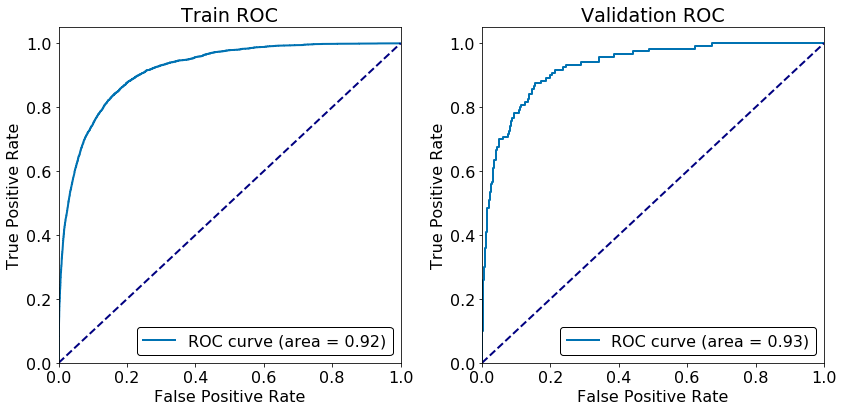

In [61]:
plt.style.use('seaborn-colorblind')
plt.rcParams.update({'font.size': 16, 
                     'legend.framealpha':1, 
                     'legend.edgecolor':'inherit'}) 

plt.figure(figsize=(12, 6))

plt.subplot(121)

fpr, tpr, _ = roc_curve(y, oof)
roc_auc = auc(fpr, tpr)
lw = 2
plt.plot(fpr, tpr, 
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Train ROC')
plt.legend(loc="lower right")

plt.subplot(122)

fpr, tpr, _ = roc_curve(y_test, ypred)
roc_auc = auc(fpr, tpr)
lw = 2
plt.plot(fpr, tpr, 
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Validation ROC')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

In [62]:
val_acc = accuracy_score(y_test, np.round(ypred))
print("validation accuracy: {:.3f}".format(val_acc))

validation accuracy: 0.936


In [67]:
tn, fp, fn, tp = confusion_matrix(y_test, np.round(X_test[:, -1])).ravel()

accuracy = (tp + tn) / len(y_test)
# precision is the fraction of correctly identified positive samples
# precision asks:"Of all the samples identified as positives, how many were correct?"
precision = tp / (tp + fp)
# recall is the ability of the model to identify positive samples 
# recall asks:"Of all the positive samples in the dataset, how many were identified by the model?"
recall = tp / (tp + fn)

print("CNN Stats:")

print("Model accuracy: {:.2f}".format(accuracy))
print("Model precision: {:.2f}".format(precision))
print("Model recall: {:.2f}".format(recall))

print("\nConfusion Matrix: ")
print(confusion_matrix(y_test, np.round(X_test[:, -1])))

tn, fp, fn, tp = confusion_matrix(y_test, np.round(ypred)).ravel()

accuracy = (tp + tn) / len(y_test)
# precision is the fraction of correctly identified positive samples
# precision asks:"Of all the samples identified as positives, how many were correct?"
precision = tp / (tp + fp)
# recall is the ability of the model to identify positive samples 
# recall asks:"Of all the positive samples in the dataset, how many were identified by the model?"
recall = tp / (tp + fn)

print("\nXGBoost Stats:")

print("Model accuracy: {:.2f}".format(accuracy))
print("Model precision: {:.2f}".format(precision))
print("Model recall: {:.2f}".format(recall))

print("\nConfusion Matrix: ")
print(confusion_matrix(y_test, np.round(ypred)))

CNN Stats:
Model accuracy: 0.83
Model precision: 0.30
Model recall: 0.85

Confusion Matrix: 
[[1153  240]
 [  18  102]]

XGBoost Stats:
Model accuracy: 0.94
Model precision: 0.59
Model recall: 0.63

Confusion Matrix: 
[[1340   53]
 [  44   76]]


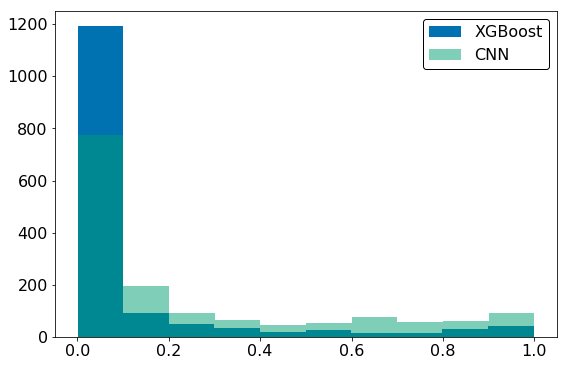

In [64]:
plt.style.use('seaborn-colorblind')
plt.rcParams.update({'font.size': 16, 
                     'legend.framealpha':1, 
                     'legend.edgecolor':'inherit'}) 
plt.figure(figsize=(9, 6))

plt.hist(ypred, label='XGBoost')
plt.hist(X_test[:, -1], label='CNN', alpha=.5)
plt.legend()
plt.show()

In [ ]:
# Next try "test time augmentation" 
'''
# 
transform_TTA = transforms.Compose([
    transforms.RandomRotation(degrees=5),
    transforms.ColorJitter(brightness=32. / 255.,saturation=0.5),
    transforms.RandomResizedCrop(size=256, scale=(0.5, 1.0), ratio=(0.8, 1.2)),
    transforms.RandomVerticalFlip(),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])


class TTADataset(torch.utils.data.Dataset):
    def __init__(self, df, path_to_files):
        # 1. Initialize file paths or a list of file names.
        self.path = path_to_files
        self.df = df

    def __getitem__(self, index):
        # 1. Read one data from file (e.g. using numpy.fromfile, PIL.Image.open).
        
        # load X 
        img_name = self.df['image_id'].values[index]
        img_path = self.path + img_name + ".jpg"
        img = plt.imread(img_path)
        
        # determine meta data 
        meta = self.df[meta_features].values[index]
        meta_data = np.array([encoder[str(m)] for m in meta])
        
        # load y 
        label = self.df["target"].values[index]
        target = torch.tensor(label, dtype=torch.float32)
        
        # 2. Preprocess the data (e.g. torchvision.Transform).
        img = Image.fromarray(img)
        #img = img.resize((256, 256))
        img_processed = transform_TTA(img)
        
        # 3. get meta data 
        meta = self.df[meta_features].values[index]
        meta_data = np.array([encoder[str(m)] for m in meta])
        
        # 3. Return a data pair (e.g. image and label).
        return img_processed, meta_data, target
        
    def __len__(self):
        # total size of your dataset.
        return self.df.shape[0]

N_TTA = 5
batch_size = 1
valid_dataset = TTADataset(val_df, path)                                               
valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset, 
                                           batch_size=batch_size)   

ypred_TTA = np.zeros((len(ypred), N_TTA))

model = model.eval()
for j in range(N_TTA):
    for i, (images, meta_data, labels) in enumerate(tqdm(valid_loader)):
        images = images.to(device)

        # Forward pass
        embed = model.embedding(images)
        nn_pred = model.output(embed).detach().cpu().numpy()
        embedding = embed.detach().cpu().numpy()

        # determine NN features for the set of images 
        batch_features = np.concatenate((embedding, meta_data.numpy(), nn_pred), axis=1)

        ypred_TTA[i, j] = bst.predict(xgb.DMatrix(batch_features))
ypred_TTA_mean = np.mean(ypred_TTA, 1)
'''